# Analysis of the results

In [2]:
import numpy as np
import os
import csv
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from PIL import Image

In [18]:
def get_queries(fname):
    queries = {}
    with open(fname, "r") as f:
        for line in f:
            liste = line.split("),(")
            key, liste[0] = liste[0].split(",(")
            liste[-1] = liste[-1][:-2]
            for i in range(len(liste)):
                tmp = liste[i].split(",")
                liste[i] = (int(tmp[0]), float(tmp[1]), int(tmp[2]))
            queries[int(key)] = liste
    return queries

In [19]:
fname = "../results/queries.txt"

queries = get_queries(fname)

In [2]:
plt.rcParams.update({'font.size': 22})

<Figure size 2160x1080 with 0 Axes>

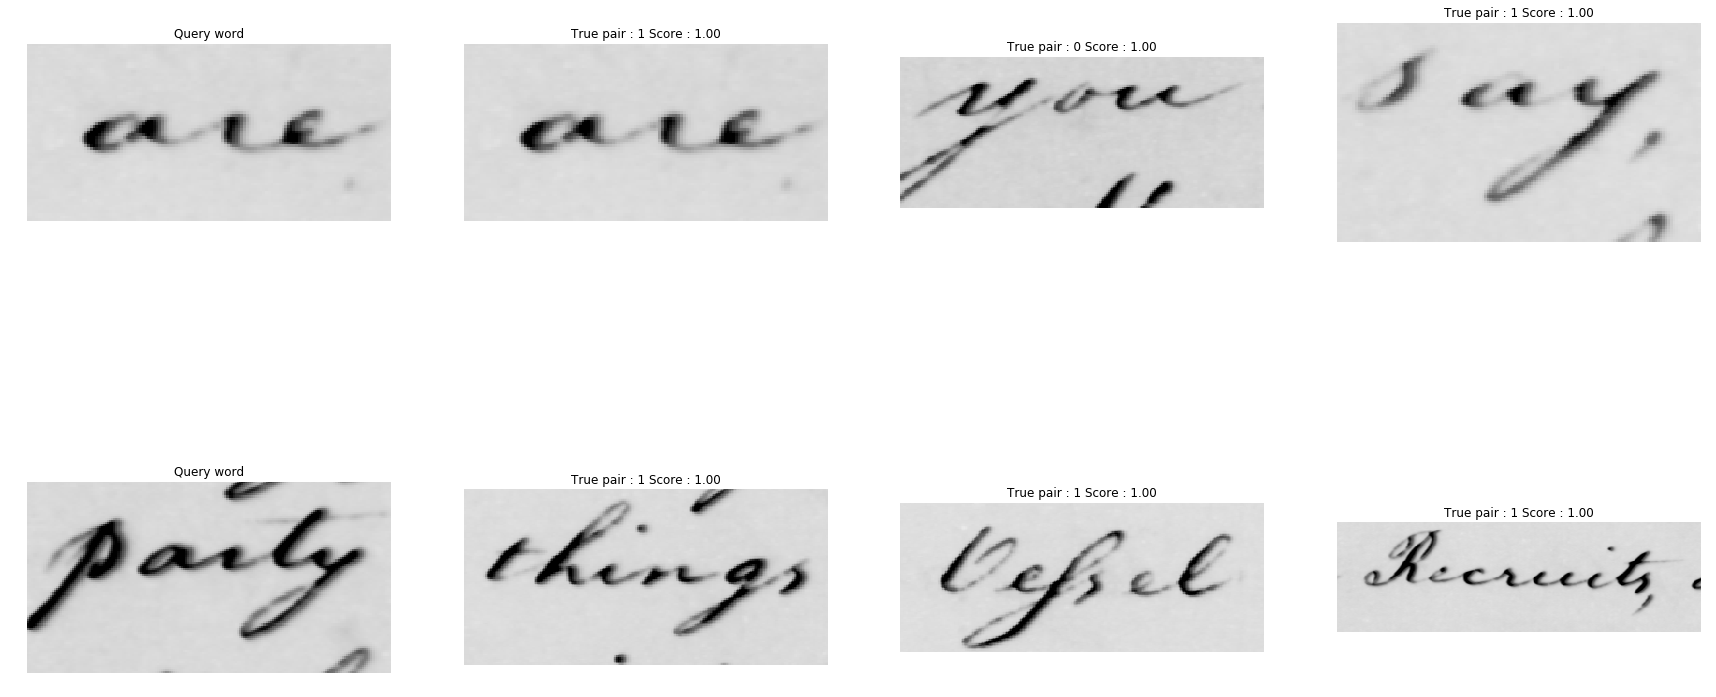

In [24]:
words = 2
first_bests = 3
nquerries = len(list(queries.keys()))
res = len(list(queries.values())[0])

plt.figure(figsize=(30,15))

keys = list(queries.keys())

np.random.shuffle(keys)
for i,qr in enumerate(keys[:words]):
    idx, score, pair = queries[qr][0]
    plt.subplot(words, first_bests+1, 1 + i*(first_bests+1))
    im = Image.open('../dataset/word-{:06d}.png'.format(int(qr)+1))
    plt.imshow(im)
    plt.axis('off')
    plt.title('Query word')
    
    plt.subplot(words, first_bests+1, 2 + i*(first_bests+1))
    im = Image.open('../dataset/word-{:06d}.png'.format(int(idx)+1))
    plt.imshow(im)
    plt.axis('off')
    plt.title('True pair : {} Score : {:.2f}'.format(int(pair),float(score)))
    for j in range(first_bests-1):
        idx, score, pair = queries[qr][j + 1]
        plt.subplot(words, first_bests+1, 3 + j + i*(first_bests+1))
        im = Image.open('../dataset/word-{:06d}.png'.format(int(idx)+1))
        plt.imshow(im)
        plt.axis('off')
        plt.title('True pair : {} Score : {:.2f}'.format(int(pair),float(score)))

plt.show()

In [33]:
curves = np.loadtxt("../results/epochs.txt", delimiter=',')
plt.rcParams.update({'font.size': 16})

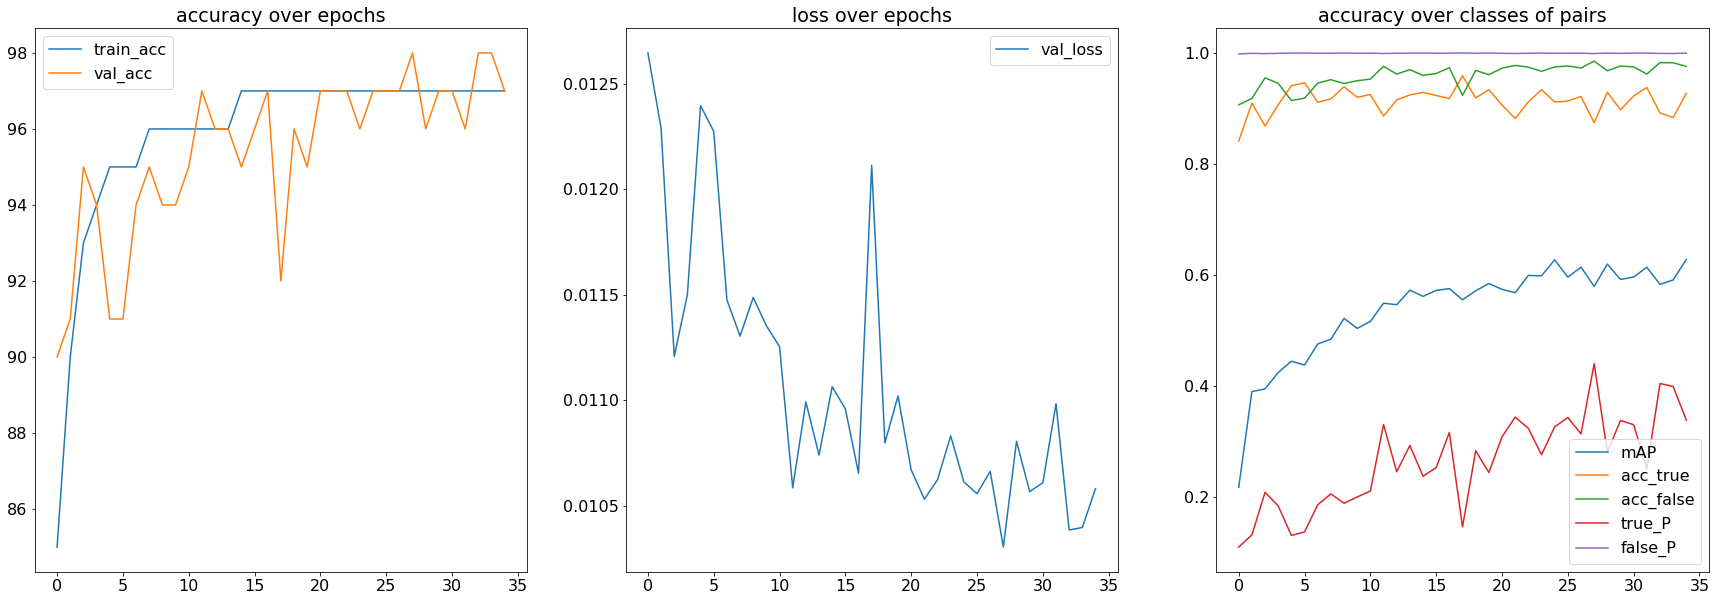

In [34]:
labels = ['train_acc', 'val_acc', 'val_loss', 'time', 'mAP', 'acc_true', 'acc_false', 'true_P', 'false_P']
plt.figure(figsize = (30,10))
plt.subplot(131)
plt.plot(curves[:,0], label = labels[0])
plt.plot(curves[:,1], label = labels[1])
plt.title('accuracy over epochs')
plt.legend()

plt.subplot(132)
plt.plot(curves[:,2], label = labels[2])
plt.title('loss over epochs')
plt.legend()

plt.subplot(133)
for i in range(5):
    plt.plot(curves[:,4+i], label = labels[4+i])
plt.title('accuracy over classes of pairs')
plt.legend()

plt.show()

# mAP for new words

In [13]:
import os, re

string_transform = {
    "strict": lambda w: w,
    "lower": lambda w: w.lower(),
    "ponctuation": lambda w: re.sub("[^\w\s]", "", w),
    "all": lambda w: re.sub("[^\w\s]", "", w).lower()
}

transf = string_transform["ponctuation"]

words = []

with open("../dataset/words.txt", "r") as f:
    words = [transf(line.strip()) for line in f]

new = []
redondant_new = set()

for i, elt in enumerate(words[3697:]):
    idx = i + 3697
    if elt not in words[:3697]:
        if elt in new:
            redondant_new.add(elt)
        new.append(elt)
        
redondant_idx = []
for i, elt in enumerate(words):
    if elt in redondant_new:
        redondant_idx.append(i)

In [14]:
print("number of queries of words that don't appear in training set: {}".format(len(redondant_idx)))

number of queries of words that don't appear in training set: 46


In [36]:
matches = np.loadtxt("../results/queries.txt", delimiter='),(', dtype=str)
queries = {}
mAP = 0
Q = 0
for i in range(matches.shape[0]):
    q, first = matches[i][0].split(",(")
    q = int(q)
    if q in redondant_idx:
        scores = [(int(first.split(",")[0]), float(first.split(",")[1]), int(first.split(",")[2]))]
        scores += [(int(elt.split(",")[0]), float(elt.split(",")[1]), int(elt.split(",")[2])) for elt in matches[i][1:-1]]
        last = matches[i][-1]
        scores.append((int(last.split(",")[0]), float(last.split(",")[1]), int(last.split(",")[2][:-1])))
        queries[q] = scores
        p_nom = 0
        p_div = 0
        cum_sum = 0
        nb_rel = 0
        for s in scores:
            if s[1] >= 0.5:
                p_div += 1
                if s[2] == 1:
                    p_nom += 1
            if s[2] == 1:
                cum_sum += p_nom * 1. / max(1, p_div)
                nb_rel += 1
        score = cum_sum * 1. / max(1, nb_rel)
        if nb_rel > 0:
            mAP += score
            Q += 1
mAP /= max(1, Q)
print("mAP: {}".format(mAP))

mAP: 0.5977790946944918


In [40]:
redondant_new_simple = redondant_new - set([
    '10th',
    '11th',
    '16th',
    '20th',
    '22d',
    '8th'
])

In [42]:
redondant_idx_simple = []
for i, elt in enumerate(words):
    if elt in redondant_new_simple:
        redondant_idx_simple.append(i)

In [43]:
len(redondant_idx_simple)

29

In [44]:
queries = {}
mAP = 0
Q = 0
for i in range(matches.shape[0]):
    q, first = matches[i][0].split(",(")
    q = int(q)
    if q in redondant_idx_simple:
        scores = [(int(first.split(",")[0]), float(first.split(",")[1]), int(first.split(",")[2]))]
        scores += [(int(elt.split(",")[0]), float(elt.split(",")[1]), int(elt.split(",")[2])) for elt in matches[i][1:-1]]
        last = matches[i][-1]
        scores.append((int(last.split(",")[0]), float(last.split(",")[1]), int(last.split(",")[2][:-1])))
        queries[q] = scores
        p_nom = 0
        p_div = 0
        cum_sum = 0
        nb_rel = 0
        for s in scores:
            if s[1] >= 0.5:
                p_div += 1
                if s[2] == 1:
                    p_nom += 1
            if s[2] == 1:
                cum_sum += p_nom * 1. / max(1, p_div)
                nb_rel += 1
        score = cum_sum * 1. / max(1, nb_rel)
        if nb_rel > 0:
            mAP += score
            Q += 1
mAP /= max(1, Q)
print("mAP: {}".format(mAP))

mAP: 0.7273858549846107
